In [5]:
%load_ext autoreload
%autoreload 2

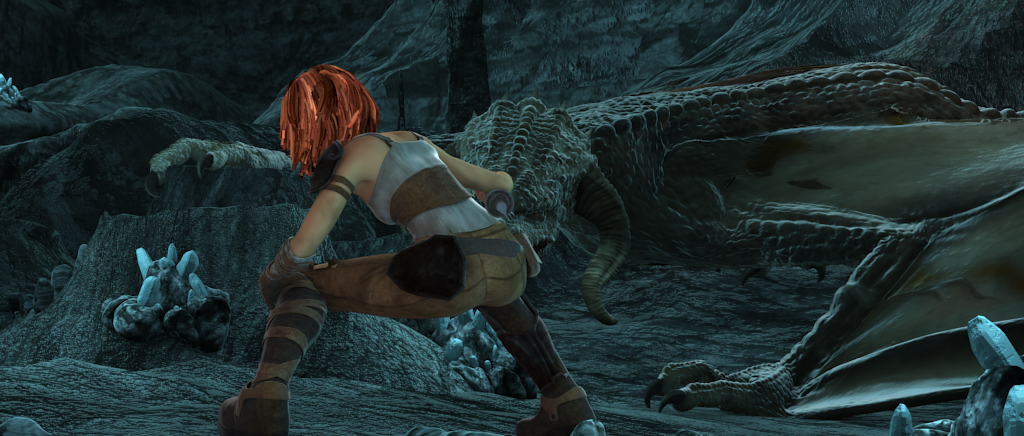

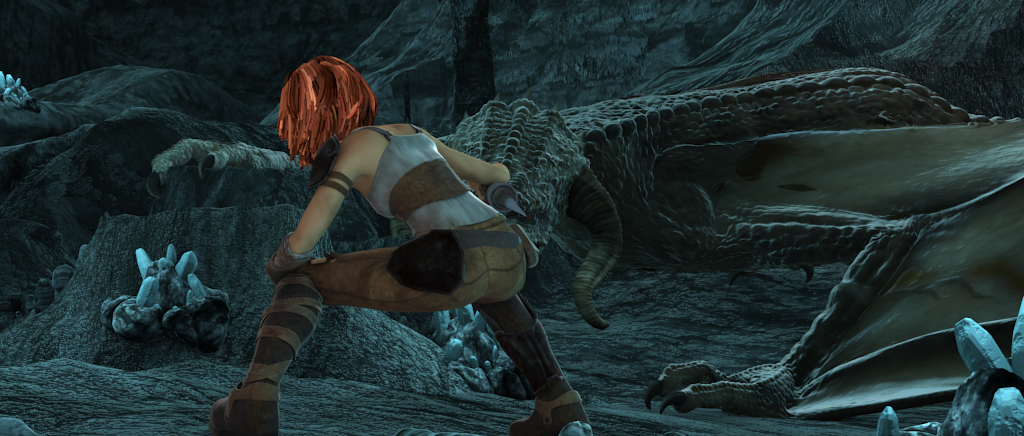

In [1]:
import requests
from PIL import Image

urls = [
    "https://storage.googleapis.com/perceiver_io/sintel_frame1.png",
    "https://storage.googleapis.com/perceiver_io/sintel_frame2.png",
]

image1 = Image.open(requests.get(urls[0], stream=True).raw)
image2 = Image.open(requests.get(urls[1], stream=True).raw)
display(image1)
display(image2)

In [2]:
from transformers import PerceiverForOpticalFlow
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PerceiverForOpticalFlow.from_pretrained("deepmind/optical-flow-perceiver")
model.to(device)

PerceiverForOpticalFlow(
  (perceiver): PerceiverModel(
    (input_preprocessor): PerceiverImagePreprocessor(
      (position_embeddings): PerceiverFourierPositionEncoding()
      (positions_projection): Identity()
      (conv_after_patches): Linear(in_features=54, out_features=64, bias=True)
    )
    (embeddings): PerceiverEmbeddings()
    (encoder): PerceiverEncoder(
      (cross_attention): PerceiverLayer(
        (attention): PerceiverAttention(
          (self): PerceiverSelfAttention(
            (layernorm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (layernorm2): LayerNorm((322,), eps=1e-05, elementwise_affine=True)
            (query): Linear(in_features=512, out_features=322, bias=True)
            (key): Linear(in_features=322, out_features=322, bias=True)
            (value): Linear(in_features=322, out_features=322, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): PerceiverSelfOutput(
            (dens

In [79]:
import numpy as np
from utils.optical_flow_helpers import compute_grid_indices, compute_optical_flow, normalize

im1 = np.array(image1) # image1 is a PIL image
im2 = np.array(image2) # image2 is a PIL image

TRAIN_SIZE = model.config.train_size
grid_indices = compute_grid_indices(im1.shape, TRAIN_SIZE)
flow = compute_optical_flow(model, normalize(im1), normalize(im2), grid_indices)

Shape of inp_piece: torch.Size([1, 2, 3, 368, 496])
Shape of inp_piece: torch.Size([1, 2, 3, 368, 496])
Shape of inp_piece: torch.Size([1, 2, 3, 368, 496])
Shape of inp_piece: torch.Size([1, 2, 3, 368, 496])
Shape of inp_piece: torch.Size([1, 2, 3, 368, 496])
Shape of inp_piece: torch.Size([1, 2, 3, 368, 496])


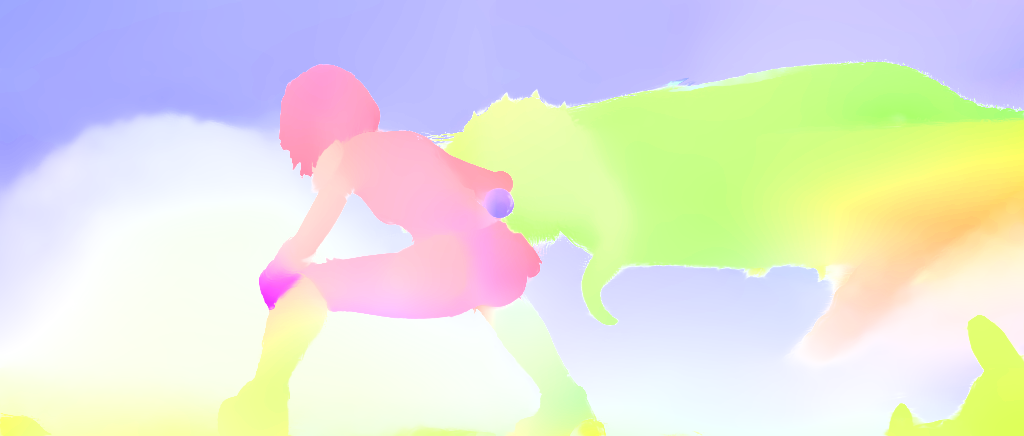

In [61]:
from utils.optical_flow_helpers import visualize_flow

bgr = visualize_flow(flow[0])
display(Image.fromarray(bgr))

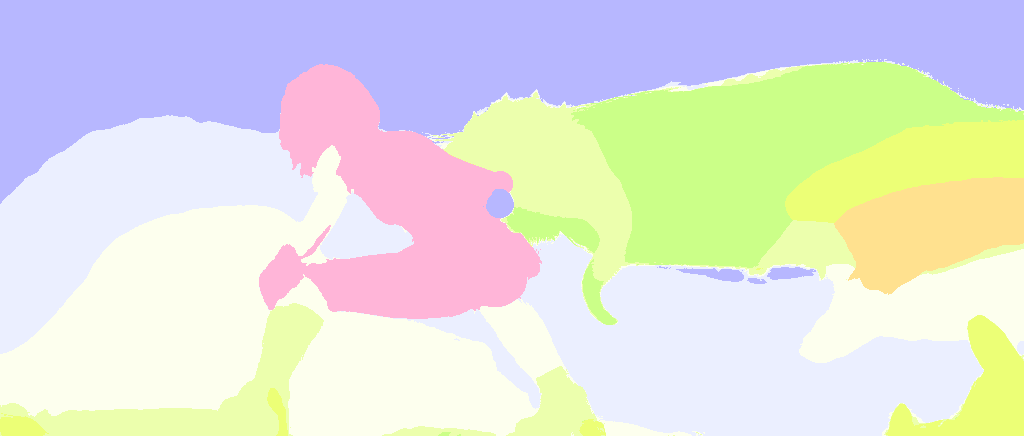

In [63]:
from utils.kmeans import kmeans, get_cluster_centers_scatter
from einops import rearrange, repeat, reduce

def run_cluster(flow, k=10):
    b, h, w, c = flow.shape
    samples = rearrange(flow, "b h w c -> b (h w) c")
    cluster_indices = []
    for i in range(flow.shape[0]):
        idx = kmeans(samples[i], k)
        cluster_indices.append(idx)
    cluster_indices = torch.stack(cluster_indices)
    centers = get_cluster_centers_scatter(samples, cluster_indices, k)
    # replace the flow with the cluster centers
    flow_clustered = torch.zeros_like(samples)
    for i in range(samples.shape[0]):
        flow_clustered[i] = centers[i][cluster_indices[i]]
    return rearrange(flow_clustered, "b (h w) c -> b h w c", h=h, w=w)

flow_torch = torch.tensor(flow, device=device, dtype=torch.float32)
flow_clustered = run_cluster(flow_torch, k=8)
bgr = visualize_flow(flow_clustered[0].cpu().numpy())
display(Image.fromarray(bgr))

In [ ]:
def warp_by_flow(image, flow):
    b, c, h, w = image.shape
    # Grid shape: b, h, w, 2
    grid = torch.stack(
        torch.meshgrid(
            torch.arange(h, device=device, dtype=torch.float32),
            torch.arange(w, device=device, dtype=torch.float32),
            indexing="ij",
        ),
        dim=-1,
    )
    grid = grid.unsqueeze(0).repeat(b, 1, 1, 1)
    # Add flow to grid
    grid += flow
    # Normalize grid to [-1, 1]
    grid = grid / torch.tensor([h - 1, w - 1], device=device, dtype=torch.float32)
    grid = grid * 2 - 1
    # Flip the last dimension to match the grid_sample format
    grid = grid.flip(-1)
    # grid_sample
    return torch.nn.functional.grid_sample(image, grid, align_corners=True)

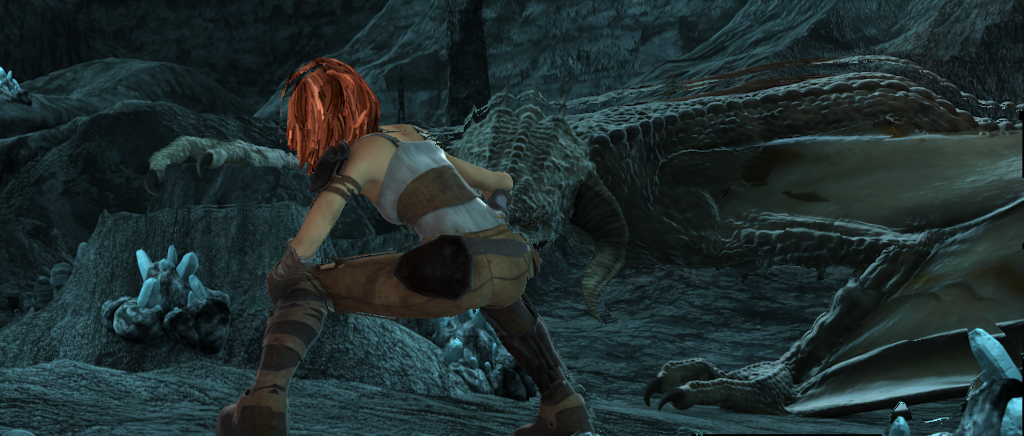

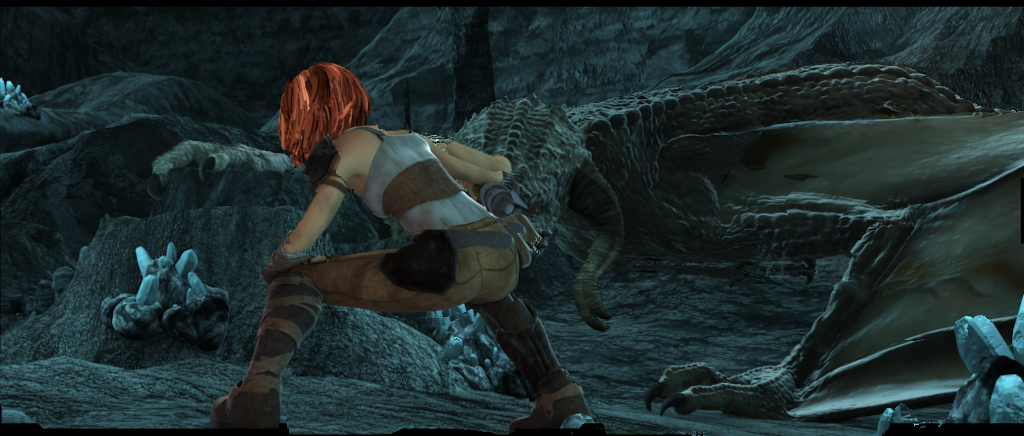

In [75]:
import cv2
# show the warped image
def show_image(im, overlay_flow=None):
    im = rearrange(im, "1 c h w -> h w c")
    im = im.cpu().numpy().astype(np.uint8)
    if overlay_flow is not None:
        bgr = visualize_flow(overlay_flow[0].cpu().numpy())
        im = cv2.addWeighted(im, 0.5, bgr, 0.5, 0)
    display(Image.fromarray(im))

im1_torch = torch.tensor(
    rearrange(np.array(image1), "h w c -> 1 c h w"), device=device, dtype=torch.float32
)

im2_torch = torch.tensor(
    rearrange(np.array(image2), "h w c -> 1 c h w"), device=device, dtype=torch.float32
)

show_image(warp_by_flow(im1_torch, flow_clustered))
show_image(warp_by_flow(im2_torch, -flow_clustered))

In [77]:
from utils.optical_flow_torch import compute_optical_flow

flow = compute_optical_flow(model, normalize(im1_torch), normalize(im2_torch))
bgr = visualize_flow(flow[0].cpu().numpy())
display(Image.fromarray(bgr))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (9x1095168 and 54x64)